# Lab Part 3: Twitter Application Development
Group members:
1. Swati Nair   ; UBIT: swatishr; Person Number: 50246994
2. Bhavik N Gala; UBIT: bhavikna; Person Number: 50248608

Citation: https://cran.r-project.org/web/packages/twitteR/twitteR.pdf

In [9]:
library(twitteR)
library(maps)
library(ggmap)

1. Setting up twitter auth

In [10]:
download.file(url="http://curl.haxx.se/ca/cacert.pem", destfile="cacert.pem")

consumerKey = "0y8DKbzLfjEAVq2gSwH1jKbt1" 
consumerSecret = "l7XhQKwX8bK5ZAJ7eOJ2jYI2Fn33U9E3hqMpZzExcK2GX9Xo1L" 
access_token = "1471799647-jrMzb5XVAf8nuYoQH8CtoqFAuH8lxDMrt9L1V2X"
access_secret = "ik5TiBJZaU6p5RxTygJJkhOzVeR7CzVxiEXKS5YDwhMv9"
setup_twitter_oauth(consumerKey,
                    consumerSecret,
                    access_token,
                    access_secret)

[1] "Using direct authentication"


1. Searching tweets with keyword "flu", number of tweets is set to 2500
2. Saving the tweets to file

In [11]:
tweets <- searchTwitter('flu', n=2500, lang="en", since=NULL, until=NULL, retryOnRateLimit=10, geocode="39.83,-98.58, 1500mi")
tweetsDF <- twListToDF(tweets)
tweets <- searchTwitter('influenza', n=2500, lang="en", since=NULL, until=NULL, retryOnRateLimit=10, geocode="39.83,-98.58, 1500mi")
tweetsDF <- rbind(tweetsDF, twListToDF(tweets))

write.csv(tweetsDF, file = "./lab1part3_data/tweets.csv")

1. Looking up users
2. Filtering user profiles without location
3. Writing the result to file

In [12]:
usernames <- tweetsDF$screenName
userProfiles <- twListToDF(lookupUsers(usernames))
userProfilesWithLocation <- userProfiles[!(userProfiles$location == ""),]

write.csv(userProfilesWithLocation, file = "./lab1part3_data/lookupUsersDataWithSomeLocation.csv")

1. Creating empty dataframe with column name as region
2. Looping through the userProfilesWithLocation dataframe
3. Reading location from a row, changing its encoding to UTF-8 to prevent errors
4. Calling geocode api for that single location
5. If the geocode api output has the administrative_area_level_1 column then save the value locations dataframe
6. Convert the values in locations dataframe to lowercase
7. Find the frequency of region in locations dataframe
8. Write it to a file

In [15]:
locations <- data.frame(region=character())

for(x in c(1:5)){
  date_time <- Sys.time()
  
  l = userProfilesWithLocation[x,]$location
  l <- iconv(l, "", "UTF-8")
  location <- geocode(l, output="more")
  if("administrative_area_level_1" %in% colnames(location)){
    nwRW = data.frame(region=location$administrative_area_level_1)
    # print(nwRW$region)
    locations <- rbind(locations, nwRW)
  }
  while((as.numeric(Sys.time()) - as.numeric(date_time))<10){}
}

locations$region <- lapply(locations$region, tolower)
locations$region <- vapply(locations$region, paste, collapse=",", character(1L))
locations <- data.frame(table(locations$region))
names(locations)[1] <- "region"

write.csv(locations, file = "./lab1part3_data/locationsFromGeocode.csv")

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=OKLAHOMA&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Inverness&sensor=false
Warning message:
"geocode failed with status OVER_QUERY_LIMIT, location = "Inverness""Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Canada&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=St%20Marys,%20WV&sensor=false
Warning message:
"geocode failed with status OVER_QUERY_LIMIT, location = "St Marys, WV""Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Washington,%20NH&sensor=false


1. Plot the heatmap

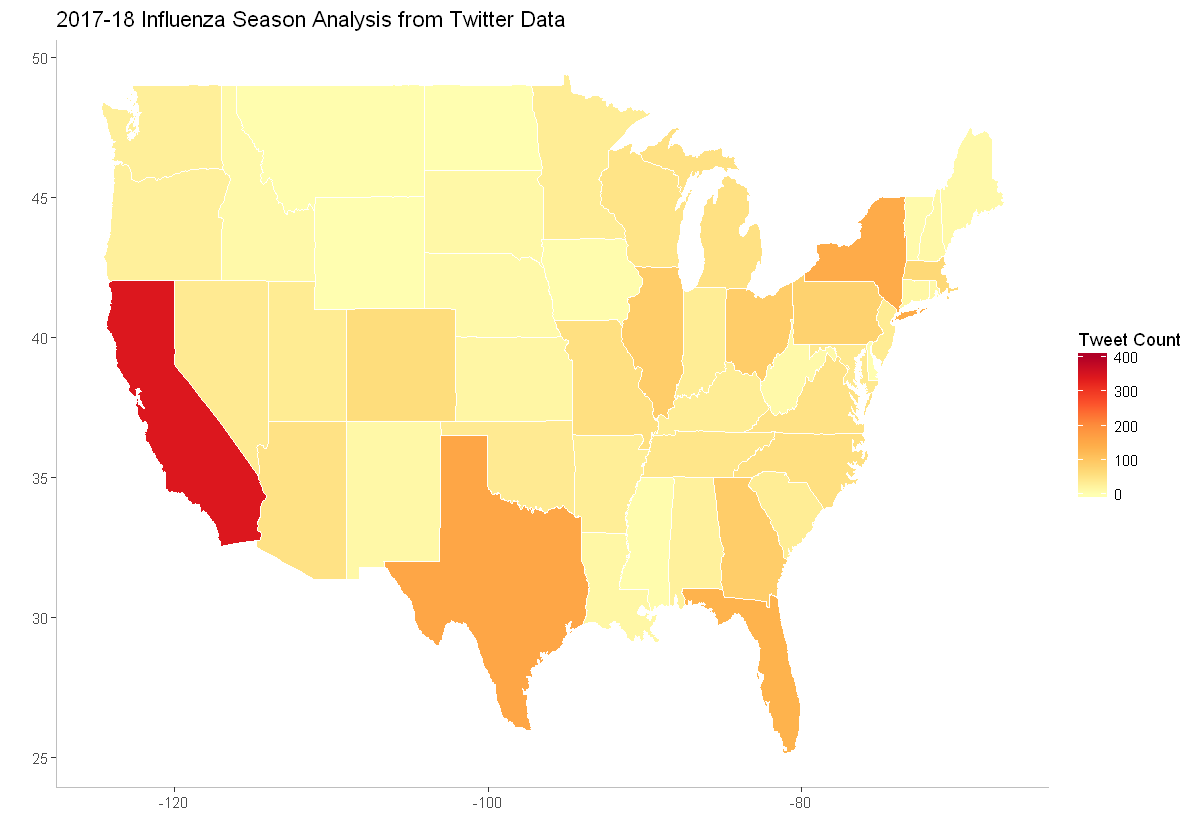

In [22]:
locations <- read.csv("./lab1part3_data/locationsFromGeocode.csv", header=TRUE, sep=",")

# CELL 6
library(ggplot2)
library(RColorBrewer)
states <- map_data("state")
mergedData <- merge(states, locations, by="region")

options(repr.plot.width = 10, repr.plot.height = 7)
p <- ggplot()
p <- p + 
  geom_polygon(data=mergedData, aes(x=long, y=lat, group = group, 
                                    fill=mergedData$Freq),colour="white")
P1 <- p + 
  scale_fill_gradientn(colours= brewer.pal(7, "YlOrRd"), limits=c(0, 400)) +
  labs(fill = "Tweet Count" ,title = "2017-18 Influenza Season Analysis from Twitter Data", x="", y="")
P1 + theme(axis.line = element_line(colour = "grey"),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(),
           panel.border = element_blank(),
           panel.background = element_blank())
